In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import auc, precision_recall_curve
import numpy as np
import itertools
import seaborn as sns

In [2]:
snp_dict = pd.read_csv('~/utils/ukb/idx/22.rsid', sep='\t', header=None, index_col=1)[0]

In [3]:
color_dict={'sparsepro': 'orange',
            'sparsepro_anno': 'red',
            'sparsepro_annopoly': 'pink',
            'sparsepro_anno_all': 'darkred',
            'sparsepro_cs_all': 'purple',
            'sparsepro_cspoly': 'blue'}

In [4]:
name_dict={'sparsepro': 'SparsePro-',
           'sparsepro_anno': 'SparsePro+',
           'sparsepro_annopoly': 'SparsePro+PolyFun',
           'sparsepro_anno_all': 'SparsePro+1.0',
           'sparsepro_cs_all': 'SparsePro+Misspecified',
           'sparsepro_cspoly': 'SparsePro+Misspecified PolyFun'}

## Plotting functions

In [5]:
def get_Tv_PIP(folder, ite, snp_dict, method):
    """get results"""
    z = pd.read_csv(os.path.join(folder, 'C{}_22.z'.format(ite)), header=None, sep='\t')
    pip = pd.read_csv(os.path.join(folder, 'sparsepro', 'C{}.pip'.format(ite)), sep='\t', header=None)
    df_res = pd.merge(z, pip, on=[0,1], how='left').fillna(0.0)
    causal = pd.read_csv(os.path.join(folder, 'C{}.causal'.format(ite)), header=None, sep='\t')[0]
    df_res['causal'] = df_res[0].isin(snp_dict.get(causal))
    df_res.columns = ['SNP', 'z', 'sparsepro', 'causal']
    for m in method:
        if m == 'sparsepro_anno' and not os.path.exists(os.path.join(folder, m, 'C{}.pip'.format(ite))):
            df_res[m] = df_res.iloc[:, 2]
        else:
            pip = pd.read_csv(os.path.join(folder, m, 'C{}.pip'.format(ite)), sep='\t', header=None)[[0,1,2]]
            pip.columns = ['SNP', 'z'] + [m]
            df_res = pd.merge(df_res, pip, on=['SNP', 'z'], how='left').fillna(0.0)
    return df_res

In [6]:
def ant_plot(ax, Tv, PIP1, PIP2, name1, name2):
    """plot PIP contrast"""
    ax.scatter(x=PIP1[[not i for i in Tv]], y=PIP2[[not i for i in Tv]], c='black', s=100, label='Non-causal')
    ax.scatter(x=PIP1[Tv], y=PIP2[Tv], c='red', s=100, label='Causal')
    ax.set_xlabel(name1, fontsize = 25)
    ax.set_ylabel(name2, fontsize = 25)
    ax.legend(loc='lower center',bbox_to_anchor=(0.5,-0.3))
    ax.grid()
    return ax

In [7]:
def ant_plot_method(df_PIP, method, name_dict):
    '''ant plot for genome-wide simulation with annotation enrichment'''
    plist = [pair for pair in itertools.combinations(method, 2)]
    fig, axs = plt.subplots(1, len(plist), figsize=(9*len(plist), 9))
    if len(plist)==1:
        ant_plot(axs, df_PIP['causal'], df_PIP[plist[0][0]], df_PIP[plist[0][1]], '{} PIP'.format(name_dict[plist[0][0]]), '{} PIP'.format(name_dict[plist[0][1]]))
    else:
        for i, ax in enumerate(axs):
            ant_plot(ax, df_PIP['causal'], df_PIP[plist[i][0]], df_PIP[plist[i][1]], '{} PIP'.format(name_dict[plist[i][0]]), '{} PIP'.format(name_dict[plist[i][1]]))

In [9]:
def prc_plot(ax, PIP, Tv, name, color):
    precision, recall, thresholds = precision_recall_curve(Tv, PIP)
    ax.plot(recall, precision, label=name+": "+"{:.4f}".format(auc(recall, precision)), color=color)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    return ax

In [10]:
def prc_plot_method(df_PIP, method, color_dict, name_dict):
    fig, ax = plt.subplots(figsize=(10,10))
    for m in method:
        prc_plot(ax, df_PIP[m], df_PIP['causal'], '{}'.format(name_dict[m]), color_dict[m])
    ax.legend()

In [11]:
def calib_plot(ax, Tv, PIP, name, color):
    cp, mpv = calibration_curve(Tv, PIP, strategy='uniform')
    ax.plot(mpv, cp, label=name, color=color)
    ax.set_ylabel('Actual Precision')
    ax.set_xlabel('Expected Precision')
    return ax

In [12]:
def calibration_plot_method(df_PIP, method, color_dict, name_dict):
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.plot([0, 1], [0, 1], '--', color='gray')  # Add diagonal line
    for m in method:
        calib_plot(ax, df_PIP['causal'], df_PIP[m], '{}'.format(name_dict[m]), color_dict[m])
    ax.legend()

In [13]:
def get_Tv_cs(folder, ite, snp_dict, method):
    causal = pd.read_csv(os.path.join(folder, 'C{}.causal'.format(ite)), header=None, sep='\t')[0]
    if not os.path.exists(os.path.join(folder, method, 'C{}.cs'.format(ite))) and method=='sparsepro_anno':
        cs = pd.read_csv(os.path.join(folder, 'sparsepro', 'C{}.cs'.format(ite)), sep='\t')
    else:
        cs = pd.read_csv(os.path.join(folder, method, 'C{}.cs'.format(ite)), sep='\t')
    tcs = len(cs)  # total cs
    if tcs == 0:
        return 0, 0, 0
    snpset = set(snp_dict.get(causal))
    cseff = [set(i.split('/')) for i in cs['cs']]
    cstrue = [i & snpset for i in cseff]
    sc = np.sum([len(i)>0 for i in cstrue])  # right cs
    tss = np.sum([len(i) for i in cseff])  # total set size
    return tcs, sc, tss

In [14]:
def get_coverage_power_size(folder, snp_dict, method, ncausal=100, nite=22):
    tcs, sc, tss = tuple(sum(x) for x in zip(*[get_Tv_cs(folder, i, snp_dict, method) for i in range(1, 1+nite)]))
    coverage = sc/tcs
    size = tss/tcs
    power = sc/ncausal/nite
    return coverage, size, power

In [15]:
def get_auprc(PIP, Tv):
    precision, recall, thresholds = precision_recall_curve(Tv, PIP)
    return auc(recall, precision)

## AUPRC summary

## Set summary

## Plotting examples

In [18]:
df_res2 = pd.concat([get_Tv_PIP('../sim/gw/22/ns_K100_W2', ite, snp_dict, ['sparsepro_anno_all', 'sparsepro_annopoly', 'sparsepro_anno', 'sparsepro_cs_all', 'sparsepro_cspoly']) for ite in range(1, 23)])

In [19]:
mlist = ['sparsepro', 'sparsepro_anno', 'sparsepro_annopoly', 'sparsepro_anno_all', 'sparsepro_cs_all', 'sparsepro_cspoly']

In [20]:
[get_auprc(df_res2[m], df_res2['causal']) for m in mlist]

[0.9453847193324878,
 0.949758130185175,
 0.9411235956974862,
 0.9495837719346163,
 0.94640789063062,
 0.9130085501565852]

<Axes: xlabel='SparsePro+ PIP', ylabel='SparsePro+Misspecified PolyFun PIP'>

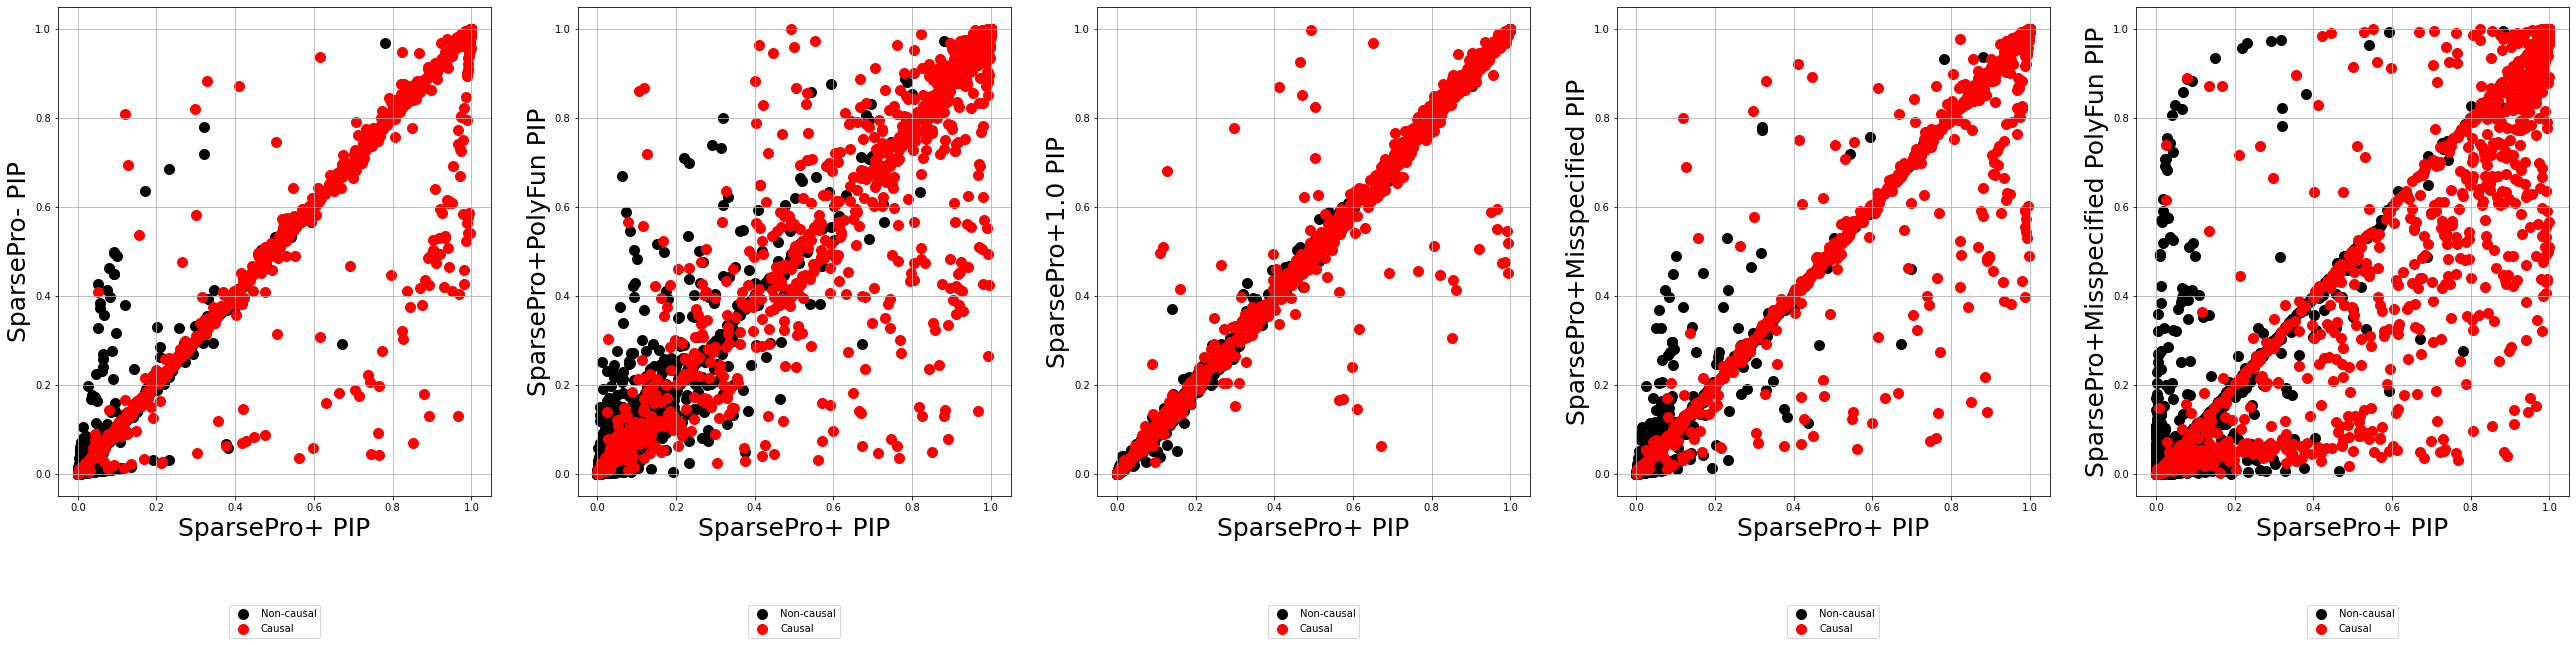

In [21]:
fig, axs = plt.subplots(1, 5, figsize=(45, 9))
ant_plot(axs[0], df_res2['causal'], df_res2['sparsepro_anno'], df_res2['sparsepro'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro-'))
ant_plot(axs[1], df_res2['causal'], df_res2['sparsepro_anno'], df_res2['sparsepro_annopoly'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+PolyFun'))
ant_plot(axs[2], df_res2['causal'], df_res2['sparsepro_anno'], df_res2['sparsepro_anno_all'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+1.0'))
ant_plot(axs[3], df_res2['causal'], df_res2['sparsepro_anno'], df_res2['sparsepro_cs_all'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+Misspecified'))
ant_plot(axs[4], df_res2['causal'], df_res2['sparsepro_anno'], df_res2['sparsepro_cspoly'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+Misspecified PolyFun'))

In [22]:
df_res1 = pd.concat([get_Tv_PIP('../sim/gw/22/ns_K100_W1', ite, snp_dict, ['sparsepro_anno_all', 'sparsepro_annopoly', 'sparsepro_anno', 'sparsepro_cs_all', 'sparsepro_cspoly']) for ite in range(1, 23)])

<Axes: xlabel='SparsePro+ PIP', ylabel='SparsePro+Misspecified PolyFun PIP'>

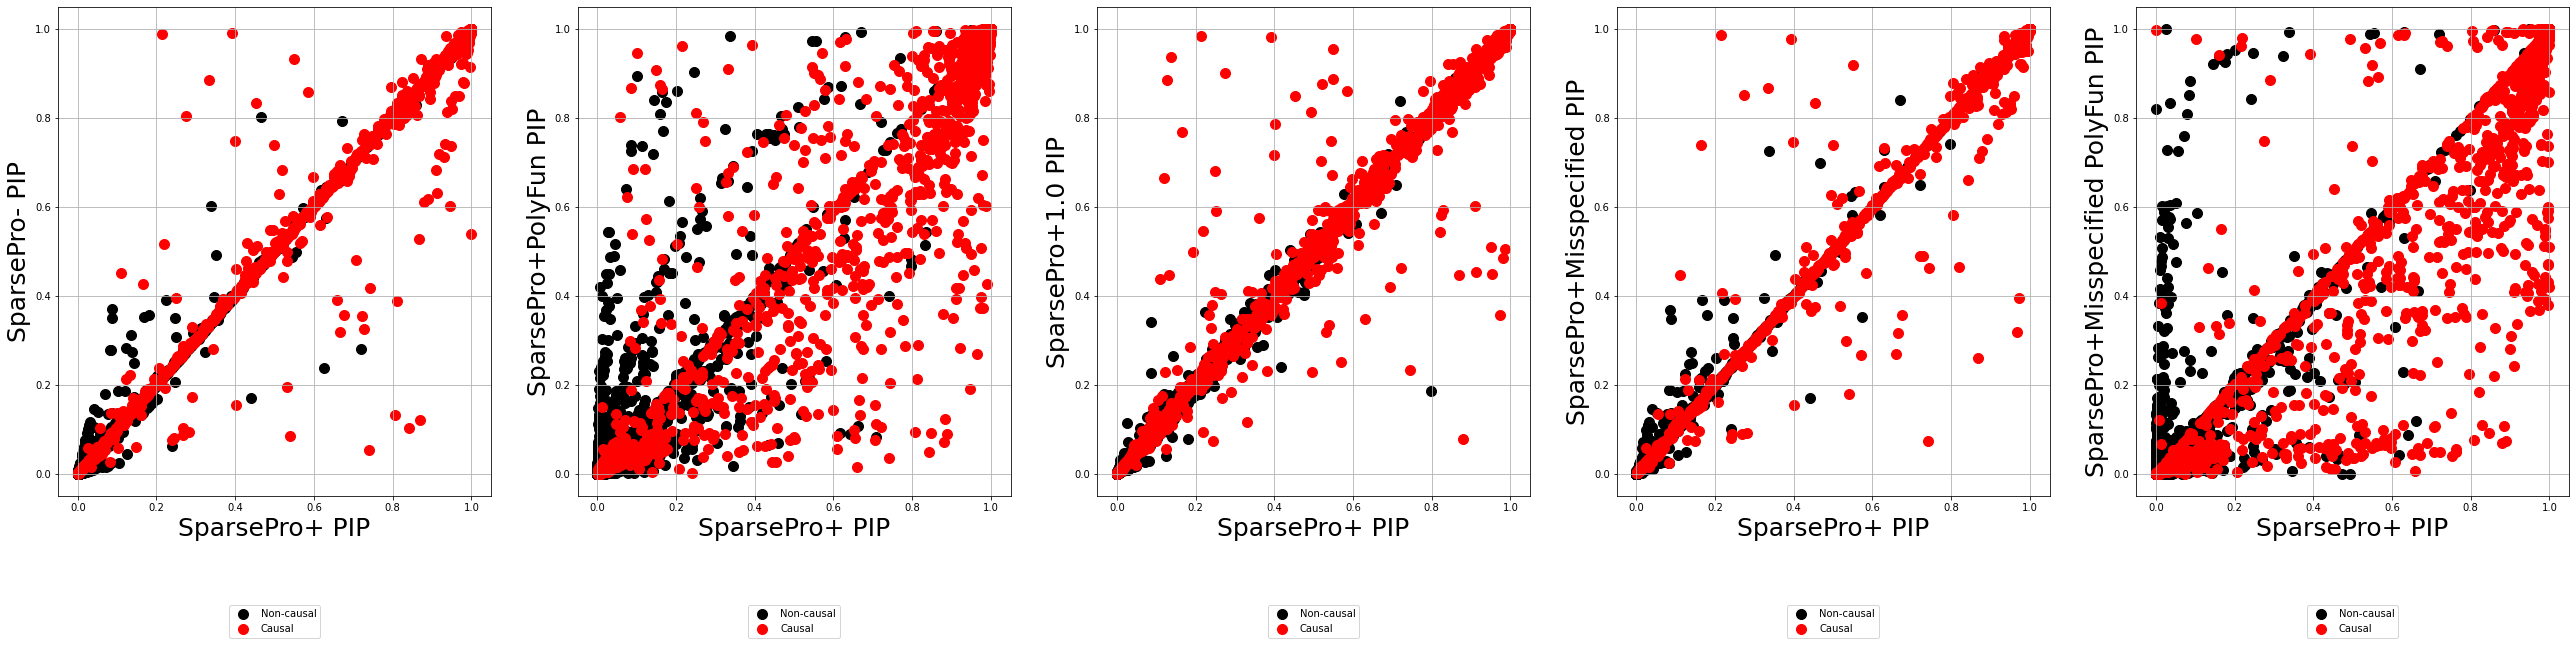

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(45, 9))
ant_plot(axs[0], df_res1['causal'], df_res1['sparsepro_anno'], df_res1['sparsepro'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro-'))
ant_plot(axs[1], df_res1['causal'], df_res1['sparsepro_anno'], df_res1['sparsepro_annopoly'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+PolyFun'))
ant_plot(axs[2], df_res1['causal'], df_res1['sparsepro_anno'], df_res1['sparsepro_anno_all'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+1.0'))
ant_plot(axs[3], df_res1['causal'], df_res1['sparsepro_anno'], df_res1['sparsepro_cs_all'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+Misspecified'))
ant_plot(axs[4], df_res1['causal'], df_res1['sparsepro_anno'], df_res1['sparsepro_cspoly'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+Misspecified PolyFun'))

In [24]:
df_res0 = pd.concat([get_Tv_PIP('../sim/gw/22/ns_K100_W0', ite, snp_dict, ['sparsepro_anno_all', 'sparsepro_annopoly', 'sparsepro_anno', 'sparsepro_cs_all', 'sparsepro_cspoly']) for ite in range(1, 23)])

<Axes: xlabel='SparsePro+ PIP', ylabel='SparsePro+Misspecified PolyFun PIP'>

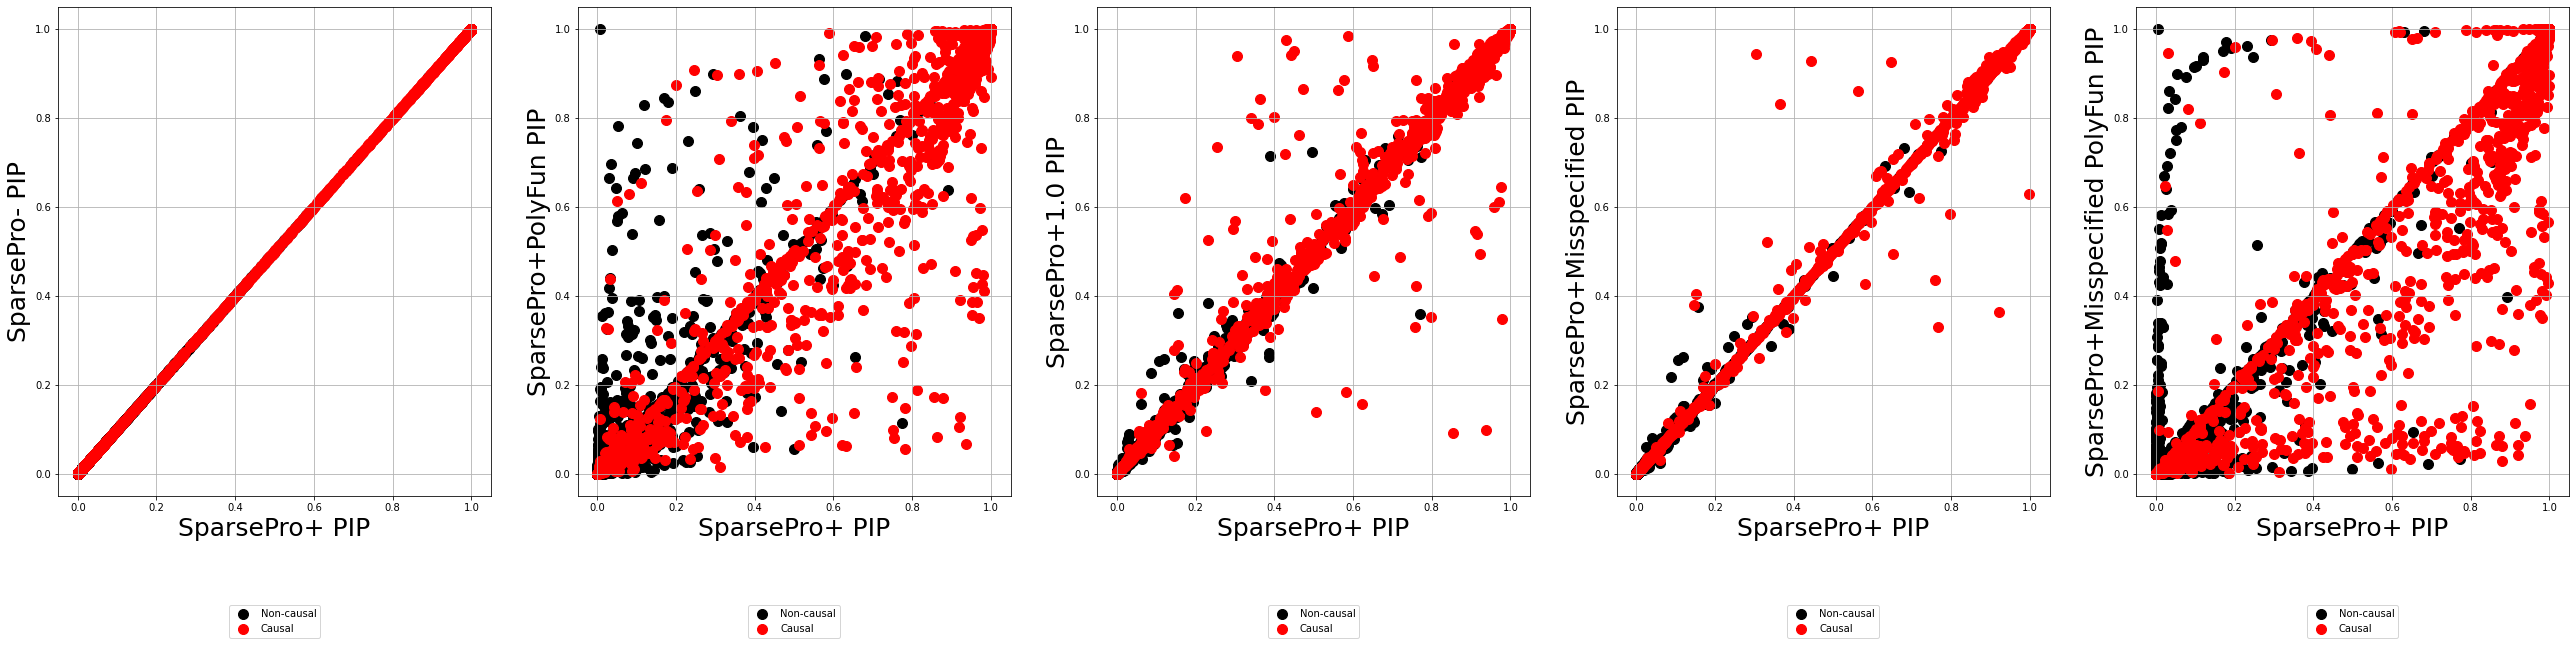

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(45, 9))
ant_plot(axs[0], df_res0['causal'], df_res0['sparsepro_anno'], df_res0['sparsepro'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro-'))
ant_plot(axs[1], df_res0['causal'], df_res0['sparsepro_anno'], df_res0['sparsepro_annopoly'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+PolyFun'))
ant_plot(axs[2], df_res0['causal'], df_res0['sparsepro_anno'], df_res0['sparsepro_anno_all'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+1.0'))
ant_plot(axs[3], df_res0['causal'], df_res0['sparsepro_anno'], df_res0['sparsepro_cs_all'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+Misspecified'))
ant_plot(axs[4], df_res0['causal'], df_res0['sparsepro_anno'], df_res0['sparsepro_cspoly'], '{} PIP'.format('SparsePro+'), '{} PIP'.format('SparsePro+Misspecified PolyFun'))

## Plotting summary

In [16]:
df_auprc = pd.read_csv('../doc/gw_auprc.txt', sep='\t')

In [17]:
mlist = ['sparsepro', 'sparsepro_anno', 'sparsepro_annopoly', 'sparsepro_anno_all', 'sparsepro_cs_all', 'sparsepro_cspoly']

In [18]:
df_auprc_long = pd.melt(df_auprc, id_vars=['W'], value_vars=[name_dict[m] for m in mlist], var_name='Method', value_name='AUPRC')

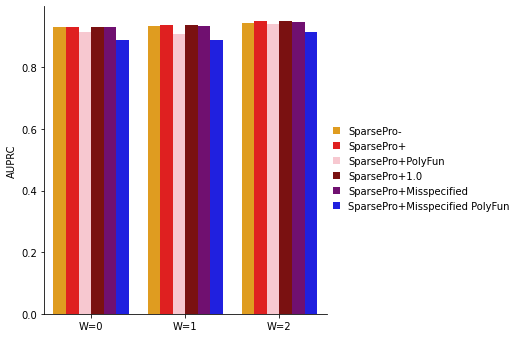

In [19]:
g = sns.catplot(df_auprc_long,
                x='W',
                y='AUPRC',
                hue='Method',
                kind='bar',
                errorbar=None,
                palette={c:color_dict[v] for v,c in name_dict.items()},
                legend=False)
g.set_xticks=(range(3))
g.set_xlabel=''
g.set_xticklabels(['W={}'.format(i) for i in [0,1,2]])
g.set_axis_labels('','AUPRC')
g.add_legend(title='', handlelength=0.7)

In [20]:
def get_ratio(wdir, method):
    """get prior inclusion probability ratio"""
    if method in ['sparsepro']:
        return 1.0
    if method in ['sparsepro_anno']:
        if os.path.exists(os.path.join(wdir, 'sparsepro/anno.W1e-05')):
            return np.exp((pd.read_csv(os.path.join(wdir, 'sparsepro/anno.W1e-05'), sep='\t')['W'].sum()))
        else:
            return 1.0
    if method in ['sparsepro_annopoly']:
        w0 = pd.concat([pd.read_csv(os.path.join(wdir, 'polyfun/annopoly.{}.snpvar_ridge_constrained.gz'.format(i)), sep='\t') for i in range(1, 23)])
        return w0['SNPVAR'].max()/w0['SNPVAR'].min()
    if method in ['sparsepro_anno_all']:
        return np.exp((pd.read_csv(os.path.join(wdir, 'sparsepro/anno.W1.0'), sep='\t')['W'].sum()))
    if method in ['sparsepro_cspoly']:
        w0 = pd.concat([pd.read_csv(os.path.join(wdir, 'polyfun/cspoly.{}.snpvar_ridge_constrained.gz'.format(i)), sep='\t') for i in range(1, 23)])
        return w0['SNPVAR'].max()/w0['SNPVAR'].min()
    if method in ['sparsepro_cs_all']:
        return np.exp((pd.read_csv(os.path.join(wdir, 'sparsepro/cs.wsep'), sep='\t')['W'].sum()))
    else:
        raise ValueError("Invalid method name.")

In [31]:
df_rt = pd.read_csv('../doc/gw_ratio.txt', sep='\t')

In [32]:
df_rt_long = pd.melt(df_rt, id_vars=['W'], value_vars=[name_dict[m] for m in mlist], var_name='Method', value_name='ratio')

In [33]:
df_rt_long['logRR'] = np.log(df_rt_long['ratio'])

In [34]:
sns.set_context('talk')

In [36]:
df_rt_long

,W,Method,ratio,logRR
0,0,SparsePro-,1.000000,0.000000
1,1,SparsePro-,1.000000,0.000000
2,2,SparsePro-,1.000000,0.000000
3,0,SparsePro+,1.000000,0.000000
4,1,SparsePro+,4.711470,1.550000
5,2,SparsePro+,9.974182,2.300000
6,0,SparsePro+PolyFun,100.000000,4.605170
7,1,SparsePro+PolyFun,100.000000,4.605170
8,2,SparsePro+PolyFun,89.566936,4.494986
9,0,SparsePro+1.0,0.895834,-0.110000


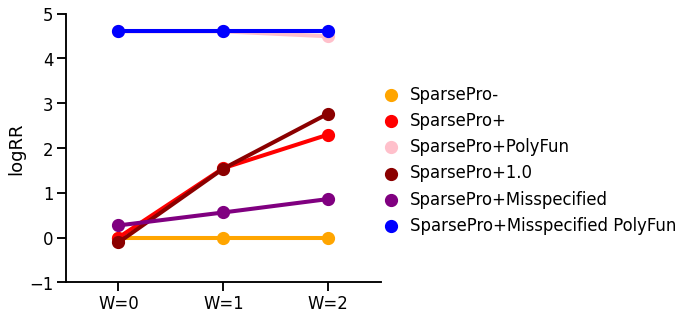

In [38]:
g = sns.catplot(df_rt_long,
                x='W',
                y='logRR',
                hue='Method',
                kind='point',
                errorbar=None,
                palette={c:color_dict[v] for v,c in name_dict.items()},
                legend=False,
                height=5,
                aspect=1.2)
g.set_xticks=(range(3))
g.set_xlabel=''
g.set_xticklabels(['W={}'.format(i) for i in [0,1,2]])
g.set_axis_labels('','logRR')
g.add_legend(title='', handlelength=0.7)
g.set(ylim=(-1, 5))

## Credible set summary

In [39]:
mlist = ['sparsepro', 'sparsepro_anno_all', 'sparsepro_annopoly', 'sparsepro_anno', 'sparsepro_cs_all', 'sparsepro_cspoly']

In [40]:
df_cs = pd.read_csv('../doc/gw_cs.txt', sep='\t')

In [41]:
sns.set_context('talk')

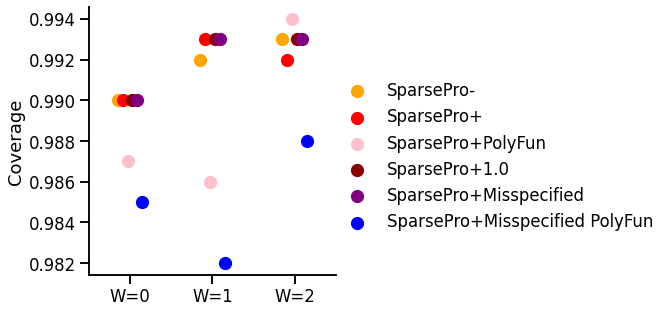

In [43]:
g = sns.catplot(df_cs,
                x='W',
                y='Coverage',
                hue='Method',
                kind='point',
                errorbar=None,
                join=False,
                palette={value: color_dict[key] for key, value in name_dict.items()},
                dodge=0.3,
                legend=False,
                height=5,
                aspect=1.2)
g.set_xticks=(range(3))
g.set_xticklabels(['W={}'.format(i) for i in [0,1,2]])
g.set_axis_labels('','Coverage')
g.add_legend(title='')

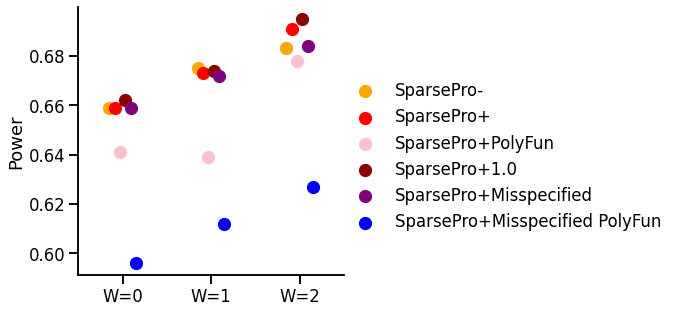

In [42]:
g = sns.catplot(df_cs,
                x='W',
                y='Power',
                hue='Method',
                kind='point',
                errorbar=None,
                join=False,
                palette={value: color_dict[key] for key, value in name_dict.items()},
                dodge=0.3,
                legend=False,
                height=5,
                aspect=1.2)
g.set_xticks=(range(3))
g.set_xticklabels(['W={}'.format(i) for i in [0,1,2]])
g.set_axis_labels('','Power')
g.add_legend(title='')

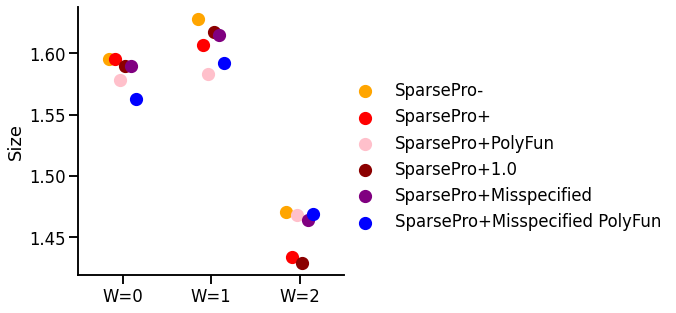

In [44]:
g = sns.catplot(df_cs,
                x='W',
                y='Size',
                hue='Method',
                kind='point',
                errorbar=None,
                join=False,
                palette={value: color_dict[key] for key, value in name_dict.items()},
                dodge=0.3,
                legend=False,
                height=5,
                aspect=1.2)
g.set_xticks=(range(3))
g.set_xticklabels(['W={}'.format(i) for i in [0,1,2]])
g.set_axis_labels('','Size')
g.add_legend(title='')

## Annotation summary